In [1]:
import os
import sys
import glob
import scipy
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

sns.set_palette("Set2")
pd.set_option('display.max_colwidth', None)


In [2]:
data_loc = '/home/mattolm/user_data/IndianMicrobiome/tables/'
Pdb = pd.read_csv(data_loc + 'IndianMicrobiome_basicinfo_v2.csv')
Pdb.head()


sample  \
0    AK_SR_1   
1    AK_SR_2   
2  AK_SR_2.2   
3    AK_SR_3   
4    AK_SR_4   

                                                                                                                              read1  \
0      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_1/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_1_R1.fastq.gz   
1      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_2_R1.fastq.gz   
2  s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2.2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_2.2_R1.fastq.gz   
3      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_3/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_3_R1.fastq.gz   
4      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_4/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_4_R1.fastq.gz   

                                                                                                                              read2  \
0      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_1/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_1_R2.fastq.gz   
1      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_2_R2.fastq.gz   
2  s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2.2/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_2.2_R2.fastq.gz   
3      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_3/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_3_R2.fastq.gz   
4      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_4/03_NODUP/NODUP_HMN_UNMAPPED_TRIM_MARKED_AK_SR_4_R2.fastq.gz   

             library_key  tribe  DNA_concentration sample_type fecal_sample  \
0    LibPlate-A2_AK-SR-1  Kabui               51.5       fecal          NaN   
1    LibPlate-A4_AK-SR-2  Kabui               28.7       fecal          NaN   
2  LibPlate-D2_AK-SR-2-2  Kabui               92.8       fecal          NaN   
3    LibPlate-A6_AK-SR-3  Kabui              411.8       fecal          NaN   
4    LibPlate-A8_AK-SR-4  Kabui               83.3       fecal          NaN   

      pairs       bases  raw_pairs    raw_bases          RL  
0  24276525  6938547858   40041788  11692202096  142.906529  
1  25189547  7192762783   30917233   9027832036  142.772770  
2  11357247  3183231459   20045323   5853234316  140.140980  
3   5682989  1595248519   11410676   3331917392  140.352948  
4   5552061  1578724021    6520759   1904061628  142.174593

In [4]:
Pdb['tribe'].value_counts()

Warli      31
Kabui      12
Gondia     11
Madia      10
Brokpa     10
Purigpa    10
Balti*      6
Balti       5
Boto        5
Name: tribe, dtype: int64

## Load assembly info

In [6]:
import io
import boto3

def get_matching_s3_objects(bucket, prefix="", suffix=""):
    """
    Generate objects in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch objects whose key starts with
        this prefix (optional).
    :param suffix: Only fetch objects whose keys end with
        this suffix (optional).
    """
    s3 = boto3.client("s3")
    paginator = s3.get_paginator("list_objects_v2")

    kwargs = {'Bucket': bucket}

    # We can pass the prefix directly to the S3 API.  If the user has passed
    # a tuple or list of prefixes, we go through them one by one.
    if isinstance(prefix, str):
        prefixes = (prefix, )
    else:
        prefixes = prefix

    for key_prefix in prefixes:
        kwargs["Prefix"] = key_prefix

        for page in paginator.paginate(**kwargs):
            try:
                contents = page["Contents"]
            except KeyError:
                return

            for obj in contents:
                key = obj["Key"]
                if key.endswith(suffix):
                    yield obj


def get_matching_s3_keys(bucket, prefix="", suffix=""):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    :param suffix: Only fetch keys that end with this suffix (optional).
    """
    for obj in get_matching_s3_objects(bucket, prefix, suffix):
        yield obj["Key"]
        
def check_s3_file(floc):
    '''
    Return True if exists and False if it does not
    '''
    bucket = floc.split('/')[2]
    prefix = '/'.join(floc.split('/')[3:])
    
    found = False
    for key in get_matching_s3_keys(bucket, prefix):
        if prefix in key:
            found = True
    return found

def store_s3_file(bucket, location, binary_string):
    s3 = boto3.resource('s3')
    object = s3.Object(bucket, location)
    object.put(Body=binary_string)
    
def load_coverage_report(s3_bucket, s3_key, sep='\t', names=None):
    '''
    https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059
    '''
    # Load the data from s3
    client = boto3.client("s3")
    obj = client.get_object(Bucket=s3_bucket, Key=s3_key)
    df = pd.read_csv(io.BytesIO(obj['Body'].read()), sep=sep, names=names)

    return df

def load_coverage_report2(s3_loc, sep='\t', names=None):
    '''
    https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059
    '''
    s3_bucket = s3_loc.split('/')[2]
    s3_key = '/'.join(s3_loc.split('/')[3:])
    
    # Load the data from s3
    client = boto3.client("s3")
    obj = client.get_object(Bucket=s3_bucket, Key=s3_key)
    df = pd.read_csv(io.BytesIO(obj['Body'].read()), sep=sep, names=names)

    return df
    
def read_s3_file(s3_bucket, s3_key):
    s3 = boto3.resource('s3')
    obj = s3.Object(s3_bucket, s3_key)
    return obj.get()['Body'].read().decode("utf-8")

def object_size(s3_bucket, s3_key):    
    return boto3.resource('s3').Bucket(s3_bucket).Object(s3_key).content_length

def object_size2(s3_loc):
    s3_bucket = s3_loc.split('/')[2]
    s3_key = '/'.join(s3_loc.split('/')[3:])
    
    return boto3.resource('s3').Bucket(s3_bucket).Object(s3_key).content_length
    
def read_s3_file2(s3_loc):
    s3 = boto3.resource('s3')
    bucket = s3_loc.split('/')[2]
    key = '/'.join(s3_loc.split('/')[3:])
    return read_s3_file(bucket, key)

def store_s3_file2(s3_loc, binary_string):
    s3 = boto3.resource('s3')
    bucket = s3_loc.split('/')[2]
    key = '/'.join(s3_loc.split('/')[3:])
    return store_s3_file(bucket, key, binary_string)


In [12]:
table = defaultdict(list)
bucket = 'czbiohub-microbiome'

for i, row in Pdb.iterrows():
    ass_loc = f"s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/{row['sample']}/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__{row['sample']}.fasta"
    try:
        assert check_s3_file(ass_loc), ass_loc
        table['sample'].append(row['sample'])
        table['assembly'].append(ass_loc)
    except:
        print(ass_loc)
    
adb = pd.DataFrame(table)
adb


s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SK_24/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SK_24.fasta


sample  \
0      AK_SR_1   
1      AK_SR_2   
2    AK_SR_2.2   
3      AK_SR_3   
4      AK_SR_4   
5      AK_SR_5   
6      AK_SR_6   
7      AK_SR_7   
8      AK_SR_8   
9      AK_SR_9   
10    AK_SR_10   
11  AK_SR_10.2   
12     AK_SW_1   
13     AK_SW_2   
14     AK_SW_3   
15     AK_SW_4   
16     AK_SW_5   
17     AK_SW_7   
18     AK_SW_8   
19     AK_SW_9   
20    AK_SW_11   
21    AK_SW_12   
22    AK_SW_14   
23     AK_SG_7   
24    AK_SG_10   
25    AK_SG_11   
26    AK_SG_16   
27    AK_SG_17   
28    AK_SG_19   
29    AK_SG_20   
30    AK_SG_22   
31    AK_SG_25   
32    AK_SG_26   
33    AK_SG_29   
34     AK_SG_2   
35     AK_SG_4   
36     AK_SG_5   
37     AK_SG_8   
38   AK_SG_8.2   
39     AK_SG_9   
40    AK_SG_12   
41    AK_SG_15   
42    AK_SG_18   
43    AK_SG_28   
44    AK_SK_10   
45    AK_SK_19   
46    AK_SK_32   
47    AK_SK_35   
48    AK_SK_44   
49     AK_SK_1   
50    AK_SK_11   
51    AK_SK_12   
52    AK_SK_13   
53    AK_SK_15   
54    AK_SK_30   
55    AK_SK_33   
56    AK_SK_37   
57  AK_SK_49.2   
58     AK_SK_2   
59    AK_SK_18   
60    AK_SK_25   
61    AK_SK_26   
62    AK_SK_27   
63    AK_SK_38   
64    AK_SK_39   
65    AK_SK_45   
66    AK_SK_48   
67    AK_SK_49   
68     AK_SK_9   
69    AK_SK_14   
70    AK_SK_29   
71    AK_SK_34   
72    AK_SK_36   
73    AK_SK_47   
74  AK_SK_47.2   
75     AK_SK_8   
76    AK_SK_40   
77    AK_SK_17   
78     AK_SK_5   
79       RS1_A   
80       RS1_B   
81       RS5_A   
82       RS5_B   
83       RS8_A   
84       RS8_B   
85      RS12_A   
86      RS12_B   
87      RS14_A   
88      RS14_B   
89       TS1_A   
90       TS1_B   
91       TS5_A   
92       TS5_B   
93       TS8_A   
94       TS8_B   
95      TS12_A   
96      TS12_B   
97      TS14_A   
98      TS14_B   

                                                                                                                                  assembly  
0         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_1/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_1.fasta  
1         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_2.fasta  
2     s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2.2/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_2.2.fasta  
3         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_3/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_3.fasta  
4         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_4/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_4.fasta  
5         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_5/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_5.fasta  
6         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_6/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_6.fasta  
7         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_7/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_7.fasta  
8         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_8/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_8.fasta  
9         s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_9/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_9.fasta  
10      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_10/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_10.fasta  
11  s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_10.2/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_10.2.fasta  
12        s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SW_1/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SW_1.fasta  
13        s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SW_2/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SW_2.fasta  
14        s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SW_3/06_ASSEMBLY/SCAFF

In [52]:
def parse_quast(Qdb):
    table = defaultdict(list)
    
    # Rename columns
    cols = list(Qdb.columns)
    
    if len(cols) == 3:
    
        c2c = {c:'Contigs' if c[-7:] == '_broken' else 'Scaffolds' for c in cols[1:]}
        Qdb = Qdb.rename(columns=c2c)
        WHAT = ['Scaffolds', 'Contigs']
    
    elif len(cols) == 2:
        WHAT = ['Scaffolds']
    
    # Re-parse
    table = defaultdict(list)
    
    # Scaffolds
    for t in WHAT:
        table['Assembly'].append(t)
        for i, row in Qdb.iterrows():
            if (row['Assembly'][0] != '#') & ~( ">=" in row['Assembly']):
                table[row['Assembly']].append(row[t])
            
    return pd.DataFrame(table)



dbs = []
for i, row in adb.iterrows():
    
    ass_loc = row['assembly']
    report_key = '/'.join(ass_loc.split('/')[:-1]) + '/QUAST_' + os.path.basename(ass_loc)[:-6] + '/report.tsv'
    qdb = load_coverage_report2(report_key)

    try:
        qdb = parse_quast(qdb)
        qdb = qdb[qdb['Assembly'] == 'Scaffolds']
        qdb['sample'] = row['sample']
        qdb = qdb[['sample', 'Total length', 'N50']].rename(columns={'Total length':'assembly_length', 'N50':'assembly_N50'})
        dbs.append(qdb)
    except:
        pass

Qdb = pd.concat(dbs).reset_index(drop=True)


In [55]:
Adb = pd.merge(adb, Qdb, how='left')
Adb.head()


sample  \
0    AK_SR_1   
1    AK_SR_2   
2  AK_SR_2.2   
3    AK_SR_3   
4    AK_SR_4   

                                                                                                                               assembly  \
0      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_1/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_1.fasta   
1      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_2.fasta   
2  s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_2.2/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_2.2.fasta   
3      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_3/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_3.fasta   
4      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/AK_SR_4/06_ASSEMBLY/SCAFFOLDS_1500_MERGED_K77_METASPADES__AK_SR_4.fasta   

  assembly_length assembly_N50  
0     1.05207e+08        41150  
1     1.09645e+08        44744  
2     6.47521e+07         9211  
3     4.48816e+07         6837  
4      3.8851e+07         6300

## Save

In [56]:
Adb.to_csv(data_loc + 'Assembly_info_v1.csv', index=False)

## Load co-assembly info

In [63]:
table = defaultdict(list)
bucket = 'czbiohub-microbiome'

for tribe, pdb in Pdb[Pdb['sample_type'] == 'fecal'].groupby('tribe'):
    
    ass_loc = f"s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_{tribe}/COASSEMBLY/SCAFFOLDS_min1500_tribe_{tribe}"
    try:
        assert check_s3_file(ass_loc), ass_loc
        table['tribe'].append(tribe)
        table['assembly'].append(ass_loc)
        table['samples'].append('|'.join(pdb['sample'].tolist()))
    except:
        print(ass_loc)
    
cadb = pd.DataFrame(table)
cadb.head()


tribe  \
0   Balti   
1  Balti*   
2    Boto   
3  Brokpa   
4  Gondia   

                                                                                                                     assembly  \
0    s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Balti/COASSEMBLY/SCAFFOLDS_min1500_tribe_Balti   
1  s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Balti*/COASSEMBLY/SCAFFOLDS_min1500_tribe_Balti*   
2      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Boto/COASSEMBLY/SCAFFOLDS_min1500_tribe_Boto   
3  s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Brokpa/COASSEMBLY/SCAFFOLDS_min1500_tribe_Brokpa   
4  s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Gondia/COASSEMBLY/SCAFFOLDS_min1500_tribe_Gondia   

                                                                                             samples  
0                                                       AK_SK_10|AK_SK_19|AK_SK_32|AK_SK_35|AK_SK_44  
1                                              AK_SK_47|AK_SK_47.2|AK_SK_8|AK_SK_40|AK_SK_17|AK_SK_5  
2                                                        AK_SK_9|AK_SK_14|AK_SK_29|AK_SK_34|AK_SK_36  
3         AK_SK_1|AK_SK_11|AK_SK_12|AK_SK_13|AK_SK_15|AK_SK_24|AK_SK_30|AK_SK_33|AK_SK_37|AK_SK_49.2  
4  AK_SG_7|AK_SG_10|AK_SG_11|AK_SG_16|AK_SG_17|AK_SG_19|AK_SG_20|AK_SG_22|AK_SG_25|AK_SG_26|AK_SG_29

In [70]:
dbs = []
for i, row in cadb.iterrows():
    
    ass_loc = row['assembly']
    report_key = '/'.join(ass_loc.split('/')[:-1]) + '/QUAST_' + os.path.basename(ass_loc).replace('_min1500', '') + '/report.tsv'
    qdb = load_coverage_report2(report_key)

    qdb = parse_quast(qdb)
    qdb = qdb[qdb['Assembly'] == 'Scaffolds']
    qdb['tribe'] = row['tribe']
    qdb = qdb[['tribe', 'Total length', 'N50']].rename(columns={'Total length':'assembly_length', 'N50':'assembly_N50'})
    dbs.append(qdb)

QAdb = pd.concat(dbs).reset_index(drop=True)


In [73]:
AAdb = pd.merge(cadb, QAdb, how='left')
AAdb


tribe  \
0    Balti   
1   Balti*   
2     Boto   
3   Brokpa   
4   Gondia   
5    Kabui   
6    Madia   
7  Purigpa   
8    Warli   

                                                                                                                       assembly  \
0      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Balti/COASSEMBLY/SCAFFOLDS_min1500_tribe_Balti   
1    s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Balti*/COASSEMBLY/SCAFFOLDS_min1500_tribe_Balti*   
2        s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Boto/COASSEMBLY/SCAFFOLDS_min1500_tribe_Boto   
3    s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Brokpa/COASSEMBLY/SCAFFOLDS_min1500_tribe_Brokpa   
4    s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Gondia/COASSEMBLY/SCAFFOLDS_min1500_tribe_Gondia   
5      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Kabui/COASSEMBLY/SCAFFOLDS_min1500_tribe_Kabui   
6      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Madia/COASSEMBLY/SCAFFOLDS_min1500_tribe_Madia   
7  s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Purigpa/COASSEMBLY/SCAFFOLDS_min1500_tribe_Purigpa   
8      s3://czbiohub-microbiome/Sonnenburg_Lab/IndianMicrobiome/coassembly/tribe_Warli/COASSEMBLY/SCAFFOLDS_min1500_tribe_Warli   

                                                                                                 samples  \
0                                                           AK_SK_10|AK_SK_19|AK_SK_32|AK_SK_35|AK_SK_44   
1                                                  AK_SK_47|AK_SK_47.2|AK_SK_8|AK_SK_40|AK_SK_17|AK_SK_5   
2                                                            AK_SK_9|AK_SK_14|AK_SK_29|AK_SK_34|AK_SK_36   
3             AK_SK_1|AK_SK_11|AK_SK_12|AK_SK_13|AK_SK_15|AK_SK_24|AK_SK_30|AK_SK_33|AK_SK_37|AK_SK_49.2   
4      AK_SG_7|AK_SG_10|AK_SG_11|AK_SG_16|AK_SG_17|AK_SG_19|AK_SG_20|AK_SG_22|AK_SG_25|AK_SG_26|AK_SG_29   
5  AK_SR_1|AK_SR_2|AK_SR_2.2|AK_SR_3|AK_SR_4|AK_SR_5|AK_SR_6|AK_SR_7|AK_SR_8|AK_SR_9|AK_SR_10|AK_SR_10.2   
6                  AK_SG_2|AK_SG_4|AK_SG_5|AK_SG_8|AK_SG_8.2|AK_SG_9|AK_SG_12|AK_SG_15|AK_SG_18|AK_SG_28   
7               AK_SK_2|AK_SK_18|AK_SK_25|AK_SK_26|AK_SK_27|AK_SK_38|AK_SK_39|AK_SK_45|AK_SK_48|AK_SK_49   
8             AK_SW_1|AK_SW_2|AK_SW_3|AK_SW_4|AK_SW_5|AK_SW_7|AK_SW_8|AK_SW_9|AK_SW_11|AK_SW_12|AK_SW_14   

  assembly_length assembly_N50  
0     1.95439e+08         7426  
1     1.76591e+08         4340  
2      6.6734e+07         3425  
3     1.78944e+08         5511  
4     1.58152e+08         4720  
5     3.33949e+08         9185  
6     2.35102e+08         4572  
7     2.22268e+08         4349  
8     1.75272e+08         5095

In [74]:
AAdb.to_csv(data_loc + 'CoAssembly_info_v1.csv', index=False)


## Plot

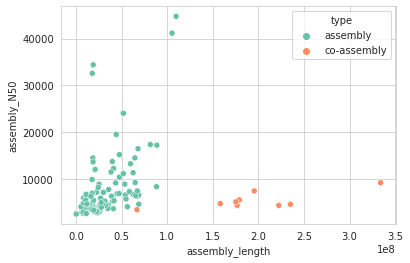

In [81]:
fdb = pd.concat([Adb, AAdb])
fdb['type'] = ['co-assembly' if t == t else 'assembly' for t in fdb['tribe']]
fdb = fdb[~fdb['assembly_length'].isna()]

sns.scatterplot(data=fdb, x='assembly_length', y='assembly_N50', hue='type')
plt.show()


## Make a new metadata sheet with assembly info and updated metadata

In [97]:
data_loc = '/home/mattolm/user_data/IndianMicrobiome/tables/'

In [101]:
Pdb = pd.read_csv(data_loc + 'IndianMicrobiome_basicinfo_v2.csv')

# Add sample for theose with double
PPdb = Pdb.copy()
PPdb['fecal_sample'] = [fs if fs == fs else s.split('.')[0] for s, fs in zip(PPdb['sample'], PPdb['fecal_sample'])]

# Update metadata
mdb = pd.read_csv(data_loc + 'IndianMicrobiome_metadata_v1.csv')
for c in ['library_key', 'tribe', 'description', 'Weight (kgs)', 'Height (cm)', 'Run', 'Fermented_foods', 'Diary_products', 'secondary_cereal', 'Daily_cereal', 'Alcoholic_beverage']:
    del mdb[c]
PPdb = pd.merge(PPdb, mdb, how='left', left_on='fecal_sample', right_on='sample').rename(columns={'sample_x':'sample'})
del PPdb['sample_y']
del PPdb['tribe']

# Add assembly info
adb = pd.read_csv(data_loc + 'Assembly_info_v1.csv')
PPdb = pd.merge(PPdb, adb, how='left')

# Save
PPdb.to_csv(data_loc + 'IndianMicrobiome_basicinfo_v3.csv', index=False)
